EDA dla danych treningowych 'Bag'

Notatnik zakłada ze jest folder train/Bag z pobranymi danymi

Podsumowanie  pracy (w 5 zdaniach):
1. Przeanalizowałeś dane sensorowe z 9 źródeł, agregując je w 5-sekundowe okna (500 próbek), co znacząco uprościło etykietowanie i obróbkę danych.
2. Przygotowałeś statystyczne wizualizacje (mean, median, std) dla każdego sensora i klasy ruchu, które pomagają zrozumieć, które sygnały są najbardziej rozróżnialne.
3. Pokazałeś, że dane magnetometru wykazują dużą zmienność i mogą mieć duży potencjał klasyfikacyjny.
4. Na podstawie uproszczonych etykiet przetestowałeś klasyfikator drzewa decyzyjnego (bez normalizacji), osiągając ok. 89% dokładności.
5. Zasugerowałeś nowatorskie podejście z użyciem RNN, które ma za zadanie odtworzyć kontekst wcześniejszego ruchu i wzbogacić klasyfikator o informacje temporalne.

In [1]:
import pandas as pd
import glob
import os

# Exploring training Data (on example of bag)
dir_path = 'train/Bag'

# Get all training data (all .txt files except the Label.txt)
sensor_files = [
    f for f in glob.glob(os.path.join(dir_path, '*.txt'))
    if os.path.basename(f).lower() != 'label.txt'
]

# Read each file into a DataFrame and store in a dictionary
sensor_data = {}
for file in sensor_files:
    key = os.path.splitext(os.path.basename(file))[0]  # e.g., 'Acc_x'
    sensor_data[key] = pd.read_csv(file, delim_whitespace=True, header=None)

# Quick summary of what was loaded
for name, df in sensor_data.items():
    print(f"{name}: {df.shape}")


/var/folders/z2/llk0y39d1137hs_3b5lcvw_c0000gn/T/ipykernel_13281/2721503661.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sensor_data[key] = pd.read_csv(file, delim_whitespace=True, header=None)
/var/folders/z2/llk0y39d1137hs_3b5lcvw_c0000gn/T/ipykernel_13281/2721503661.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sensor_data[key] = pd.read_csv(file, delim_whitespace=True, header=None)
/var/folders/z2/llk0y39d1137hs_3b5lcvw_c0000gn/T/ipykernel_13281/2721503661.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  sensor_data[key] = pd.read_csv(file, delim_whitespace=True, header=None)
/var/folders/z2/llk0y39d1137hs_3b5lcvw_c0000gn/T/ipykernel_13281/2721503661.py:18: FutureWarning: Th

Mag_y: (196072, 500)
Mag_x: (196072, 500)
Mag_z: (196072, 500)
Acc_y: (196072, 500)
Acc_x: (196072, 500)
Acc_z: (196072, 500)
Gyr_x: (196072, 500)
Gyr_y: (196072, 500)
Gyr_z: (196072, 500)


In [21]:
import pandas as pd

# Assuming you already have `sensor_data` dict from the previous cell

# Collect describe() stats for each sensor by flattening the 2D array
stats_list = []
for name, df in sensor_data.items():
    # Flatten all values to a single Series
    vals = pd.Series(df.values.flatten(), name=name)
    desc = vals.describe()    # count, mean, std, min, 25%, 50%, 75%, max
    stats_list.append(desc)

# Combine into a DataFrame: each row = one sensor file, columns = stats
summary_df = pd.DataFrame(stats_list)

# Display the summary table
print(summary_df)


            count      mean        std          min        25%        50%  \
Mag_y  98036000.0  1.149835  44.034265 -1475.943023 -16.687500   2.412736   
Mag_x  98036000.0 -8.606271  71.784579 -1483.980663 -33.437500 -10.681527   
Mag_z  98036000.0  1.209822  58.308358 -2506.864593 -21.875000   0.312500   
Acc_y  98036000.0  0.063772   4.132609   -78.769230  -1.896144  -0.214835   
Acc_x  98036000.0  2.957170   7.015196   -78.347855  -1.759668   5.259548   
Acc_z  98036000.0 -0.234529   5.910774   -78.769230  -4.830628  -0.547928   
Gyr_x  98036000.0  0.005457   0.328410   -15.096564  -0.022520   0.006097   
Gyr_y  98036000.0  0.002398   0.387297   -22.371343  -0.024635   0.002443   
Gyr_z  98036000.0 -0.000906   0.278391   -12.585312  -0.018114  -0.000775   

             75%          max  
Mag_y  19.364280  1529.080076  
Mag_x  15.604416  3158.151285  
Mag_z  21.562500  5078.943885  
Acc_y   1.637634    77.966056  
Acc_x   8.863756    78.386160  
Acc_z   4.355905    77.864723  
Gyr_x

/var/folders/z2/llk0y39d1137hs_3b5lcvw_c0000gn/T/ipykernel_13281/2074005855.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


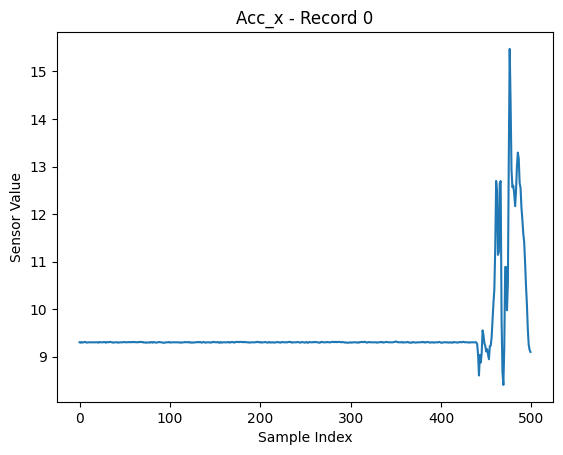

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_sensor(record_num: int, sensor_key: str, dir_path: str = 'train/Bag'):
    """
    Plot the time-series data for a given sensor and record (row index).
    
    Parameters:
    - record_num: int, row index in the file (DataFrame)
    - sensor_key: str, filename prefix (e.g., 'Acc_x', 'Gyr_y')
    - dir_path:  str, path to the folder containing the .txt files
    """
    # Construct the full file path
    file_path = os.path.join(dir_path, f"{sensor_key}.txt")
    
    # Load the data for this sensor
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
    
    # Extract the specified record
    series = df.iloc[record_num]
    
    # Plot the time-series
    plt.figure()
    plt.plot(series)
    plt.title(f"{sensor_key} - Record {record_num}")
    plt.xlabel("Sample Index")
    plt.ylabel("Sensor Value")
    plt.show()

# Example: plot the first record (row 0) of Acc_x
plot_sensor(record_num=0, sensor_key='Acc_x')


/var/folders/z2/llk0y39d1137hs_3b5lcvw_c0000gn/T/ipykernel_13281/1286138750.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)


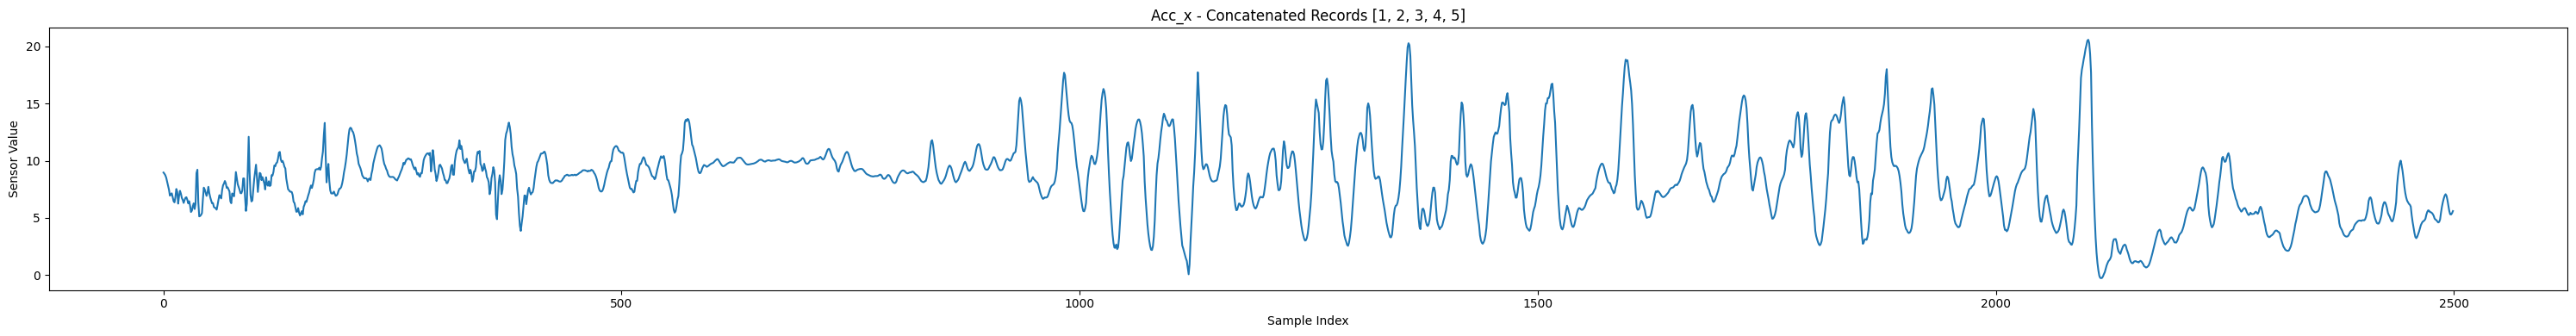

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_concatenated_sensor_records(record_nums, sensor_key, dir_path='train/Bag'):
    """
    Plot a concatenated time-series from multiple records for a given sensor.
    
    Each row in `record_nums` is appended end-to-end to form a longer series,
    and plotted as a single line. The figure width scales with the number of records.
    
    Parameters:
    - record_nums: list of int, row indices to concatenate
    - sensor_key: str, filename prefix (e.g., 'Acc_x', 'Gyr_y')
    - dir_path: str, path to the folder containing the .txt files
    """
    # Load the data file
    file_path = os.path.join(dir_path, f"{sensor_key}.txt")
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
    
    # Concatenate the specified records end-to-end
    concatenated = pd.concat([df.iloc[rec] for rec in record_nums], ignore_index=True)
    
    # Scale figure width
    width = 6 * len(record_nums)
    plt.figure(figsize=(width, 4))
    
    # Plot the concatenated series
    plt.plot(concatenated)
    plt.title(f"{sensor_key} - Concatenated Records {record_nums}")
    plt.xlabel("Sample Index")
    plt.ylabel("Sensor Value")
    plt.tight_layout()
    plt.show()

# Example usage: concatenate and plot rows 0, 1, and 2 of Acc_x
plot_concatenated_sensor_records([1, 2, 3, 4, 5], 'Acc_x')


In [24]:
import pandas as pd

# Path to the Label.txt file
label_path = 'train/Bag/Label.txt'

# Load the labels (500 columns per row, no header)
df_labels = pd.read_csv(label_path, delim_whitespace=True, header=None)

# Count unique values in each row
nunique_per_row = df_labels.nunique(axis=1)

# Identify rows with more than one unique label
rows_with_multiple = nunique_per_row[nunique_per_row > 1]

# Output results
print(f"Total rows: {df_labels.shape[0]}")
print(f"Rows with >1 unique labels: {len(rows_with_multiple)}")

if len(rows_with_multiple) > 0:
    print("Example row indices with mixed labels:", rows_with_multiple.index.tolist()[:10])


/var/folders/z2/llk0y39d1137hs_3b5lcvw_c0000gn/T/ipykernel_13281/3628746631.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_labels = pd.read_csv(label_path, delim_whitespace=True, header=None)


Total rows: 196072
Rows with >1 unique labels: 581
Example row indices with mixed labels: [96, 1530, 1581, 1800, 1944, 1998, 3408, 3417, 3609, 3645]


In [8]:
import pandas as pd

def process_labels_with_change_pct(label_path='train/Bag/Label.txt'):
    """
    Load the Label.txt, replace each row's entries with the row mode,
    and print the percentage of entries that were changed.
    Returns a list of the mode per row.
    """
    # Load the labels
    df_labels = pd.read_csv(label_path, delim_whitespace=True, header=None)
    
    # Compute the mode for each row
    row_modes = df_labels.mode(axis=1)[0]
    
    # Build a DataFrame where each row is filled with its mode
    df_equal = pd.DataFrame([ [m] * df_labels.shape[1] for m in row_modes ], 
                            columns=df_labels.columns)
    
    # Compute total elements and count matches
    total_elements = df_labels.size
    unchanged = (df_labels.values == df_equal.values).sum()
    changed = total_elements - unchanged
    pct_changed = (changed / total_elements) * 100
    
    # Print the percentage changed
    print(f"Total entries: {total_elements}")
    print(f"Changed entries: {changed} ({pct_changed:.2f}% of all values)")
    
    return row_modes.tolist()

# Example usage
labels_list = process_labels_with_change_pct()

/var/folders/z2/llk0y39d1137hs_3b5lcvw_c0000gn/T/ipykernel_13281/42345370.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_labels = pd.read_csv(label_path, delim_whitespace=True, header=None)


Total entries: 98036000
Changed entries: 55822 (0.06% of all values)


In [9]:
print(labels_list)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

In [10]:
from collections import defaultdict
import pandas as pd

def group_sensor_data_by_label(sensor_data, labels_list):
    """
    Given:
      - sensor_data: dict mapping sensor_key -> DataFrame (n_frames × n_samples)
      - labels_list: list of length n_frames with the integer label for each frame
    Returns:
      - nested dict: { sensor_key: { label_value: DataFrame_of_frames_with_that_label } }
    """
    # Determine all unique labels (e.g. 1–8)
    unique_labels = sorted(set(labels_list))
    
    grouped = {}
    for key, df in sensor_data.items():
        # Attach labels to the DataFrame temporarily
        df_labeled = df.copy()
        df_labeled['label'] = labels_list
        
        # Group by label, drop the label column in each subgroup
        label_dict = {
            label: group_df.drop(columns='label').reset_index(drop=True)
            for label, group_df in df_labeled.groupby('label')
        }
        # Ensure all labels appear, even if empty
        for label in unique_labels:
            label_dict.setdefault(label, pd.DataFrame(columns=df.columns))
        
        grouped[key] = label_dict
    
    return grouped

# Example usage:
# grouped_data = group_sensor_data_by_label(sensor_data, labels_list)
# Now, grouped_data['Acc_x'][4] is the DataFrame of all Acc_x frames labeled '4'.


In [11]:
grouped_data = group_sensor_data_by_label(sensor_data, labels_list)

In [12]:
import pandas as pd

# Assuming you already have:
#  - grouped_data: dict of { sensor_key: { label: DataFrame(frames × samples) } }

# Build a list of stats dicts
stats_rows = []
for sensor_key, label_dict in grouped_data.items():
    for label, df_frames in label_dict.items():
        # flatten all values for this sensor+label
        vals = df_frames.values.flatten()
        stats_rows.append({
            'sensor': sensor_key,
            'label': label,
            'min':    vals.min(),
            'max':    vals.max(),
            'mean':   vals.mean(),
            'std':    vals.std(),
        })

# Create a DataFrame of stats
stats_df = pd.DataFrame(stats_rows)

# (Optional) Pivot so rows are sensors, columns are labels
stats_pivot = stats_df.pivot(index='sensor', columns='label', values=['min','max','mean','std'])

# Show results
print(stats_df)         # long form
print(stats_pivot)      # wide form


   sensor  label          min          max       mean        std
0   Mag_y      1  -255.026200   811.312500  -1.727595  45.427651
1   Mag_y      2 -1087.073003   679.272044   0.475906  21.669921
2   Mag_y      3  -181.000409   240.245677  -7.416977  36.531943
3   Mag_y      4 -1160.872953  1529.080076   1.309093  44.851401
4   Mag_y      5 -1475.943023   325.619607  12.370533  66.203602
..    ...    ...          ...          ...        ...        ...
67  Gyr_z      4    -8.134453     9.225232  -0.001388   0.495172
68  Gyr_z      5    -5.032892     5.101543  -0.000485   0.067479
69  Gyr_z      6    -5.538150     8.657521  -0.000915   0.079549
70  Gyr_z      7    -4.371337     4.391815  -0.000689   0.049383
71  Gyr_z      8    -3.826716     3.949400  -0.000963   0.046265

[72 rows x 6 columns]
               min                                                     \
label            1            2           3            4            5   
sensor                                             

In [14]:
print(stats_pivot)      # wide form

               min                                                     \
label            1            2           3            4            5   
sensor                                                                  
Acc_x   -54.791870   -78.347855  -78.347855   -78.284042   -46.556492   
Acc_y   -32.849064   -38.714850  -78.769230   -44.250293   -40.408587   
Acc_z   -76.868142   -78.069858  -78.769230   -78.769230   -72.961756   
Gyr_x   -15.096564   -10.637365   -9.782674    -9.242926   -10.473857   
Gyr_y   -22.371343   -18.507198  -13.502226   -16.522332   -12.089556   
Gyr_z    -5.173287    -6.941452  -12.585312    -8.134453    -5.032892   
Mag_x  -243.728735  -935.067418 -521.889744 -1483.980663 -1032.848171   
Mag_y  -255.026200 -1087.073003 -181.000409 -1160.872953 -1475.943023   
Mag_z  -383.199724  -429.406343 -199.833412 -1217.618275 -2506.864593   

                                                    max              ...  \
label            6           7            8    

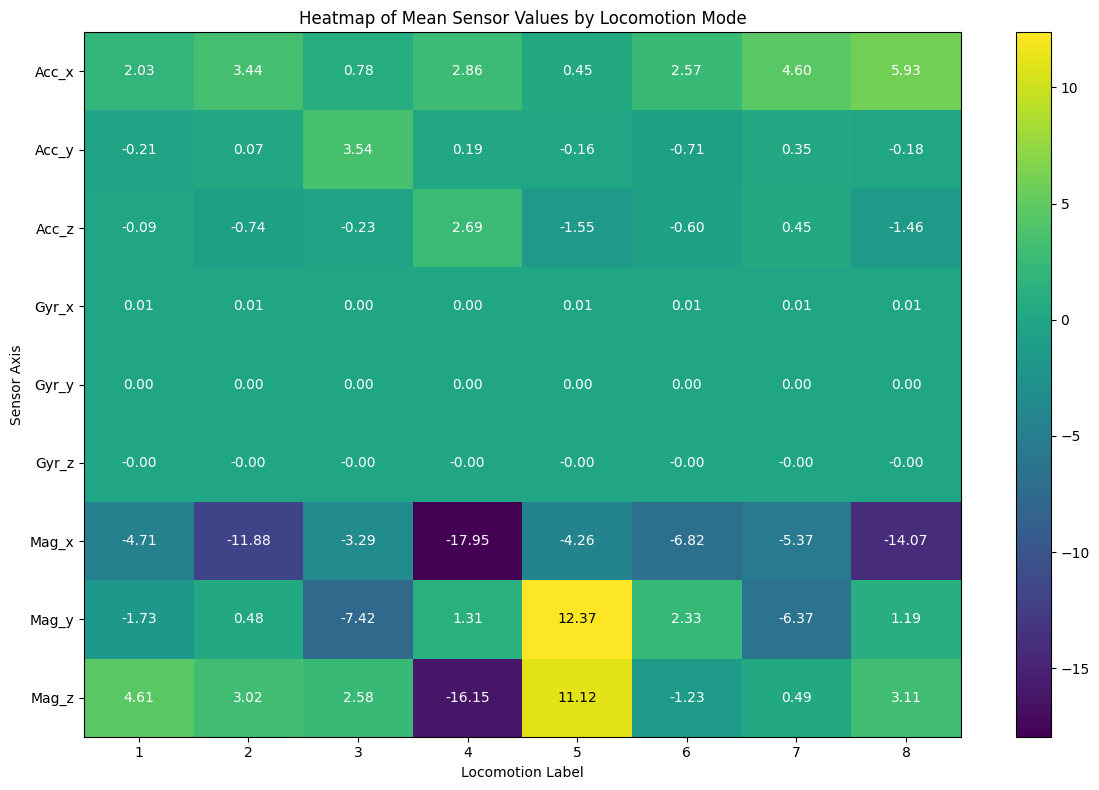

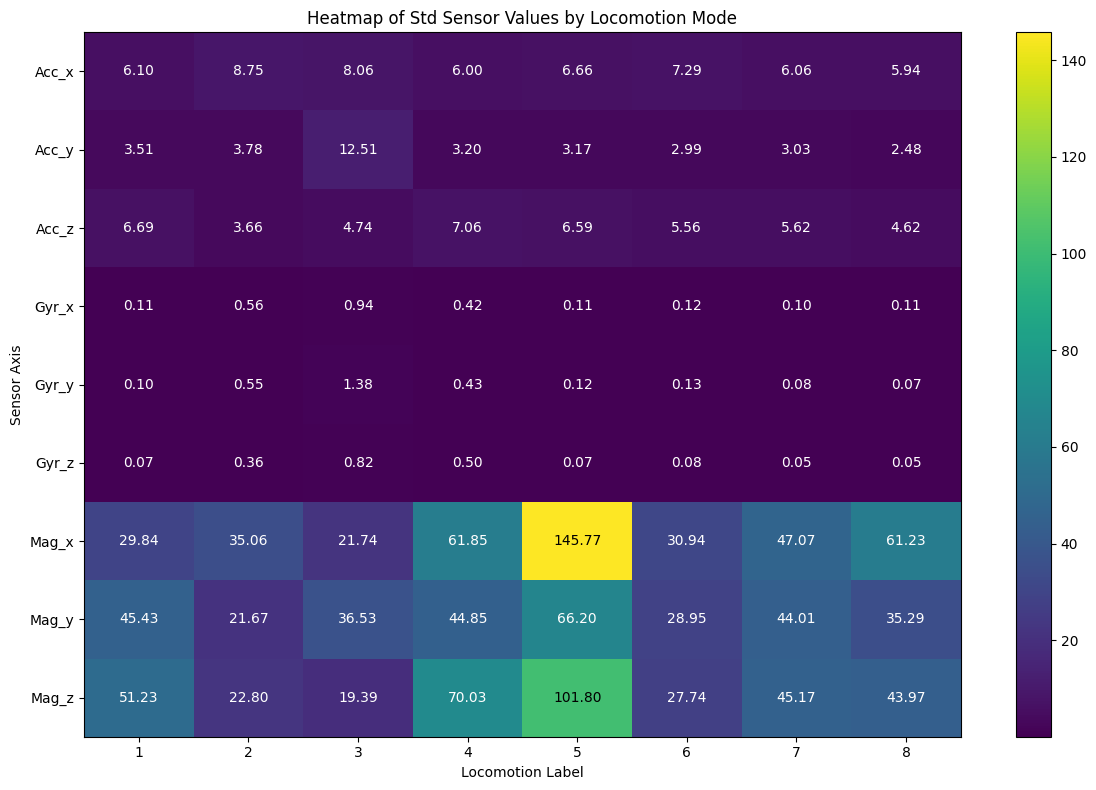

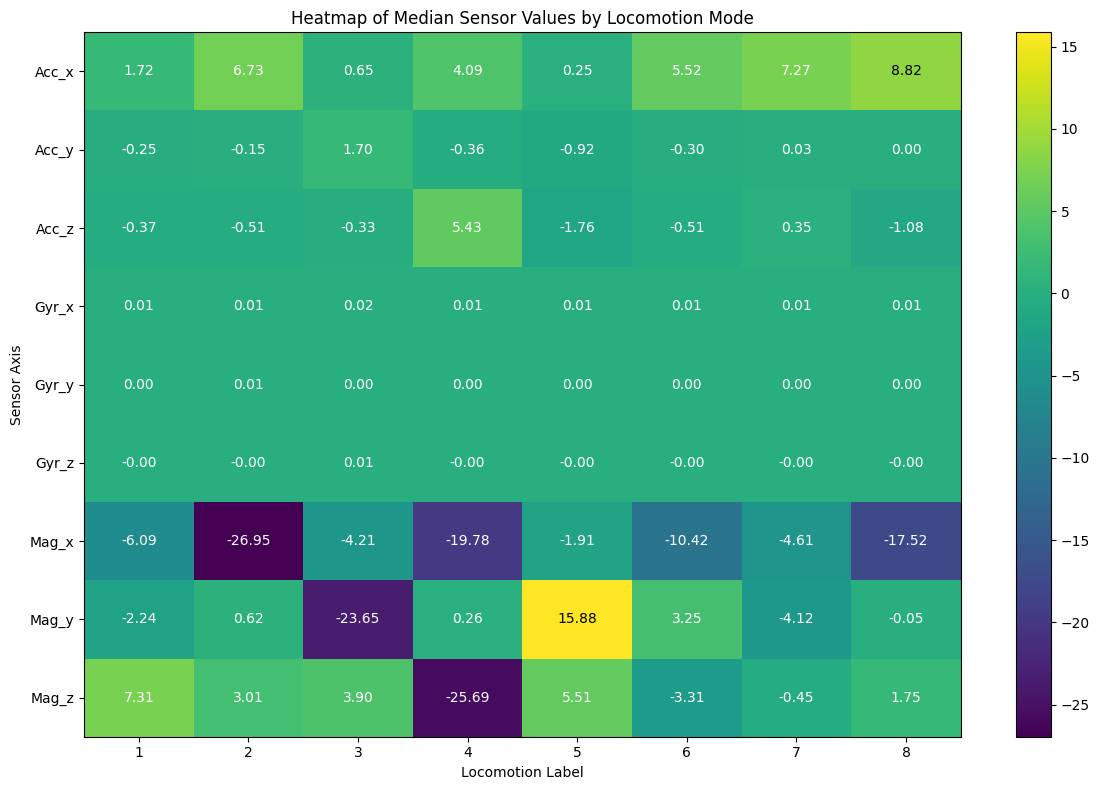

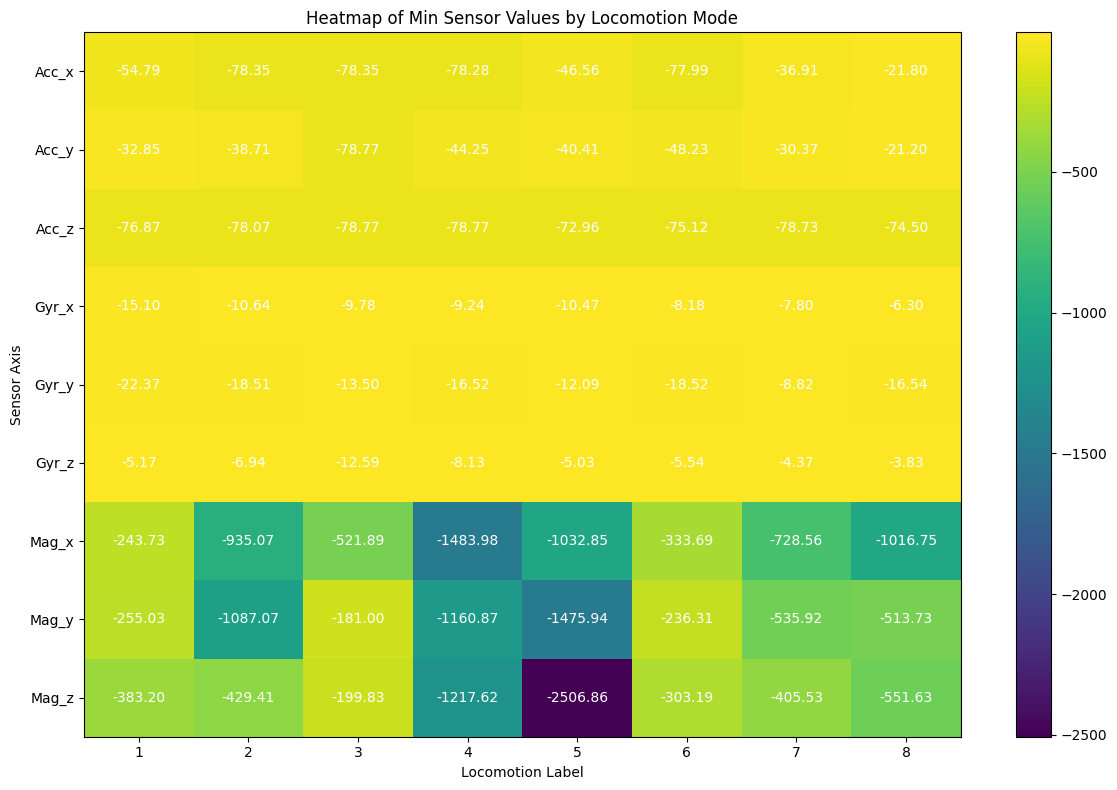

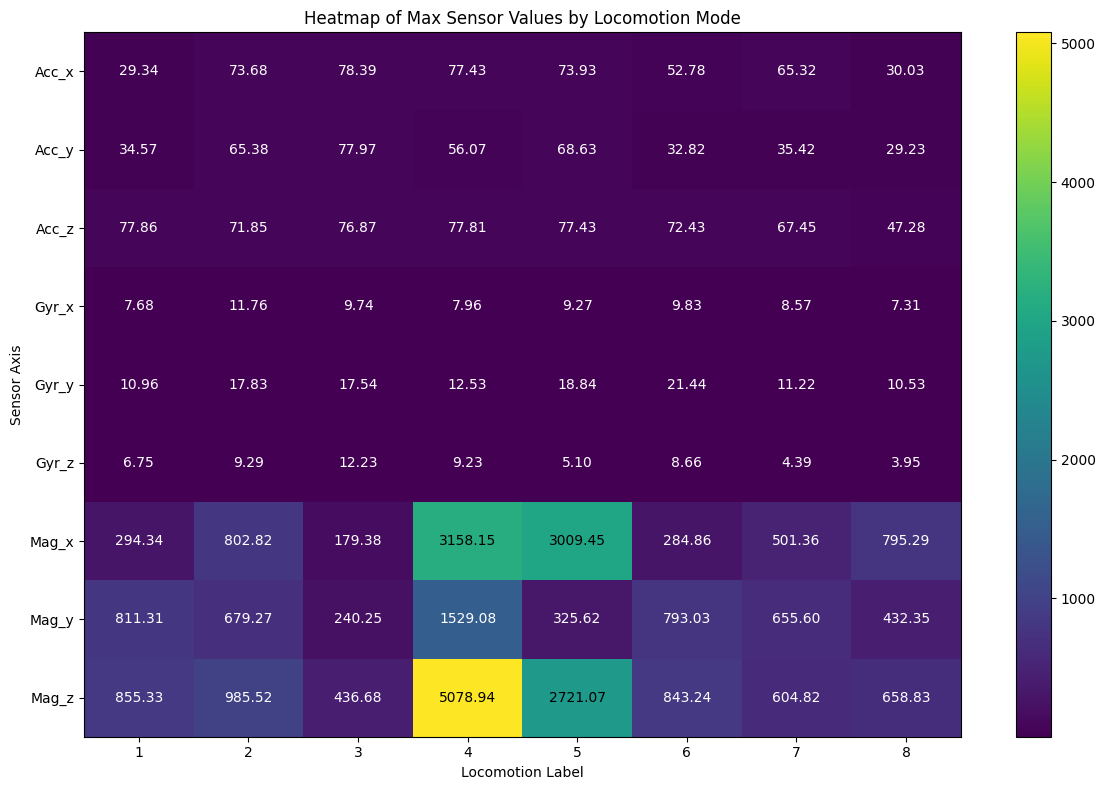

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Compute multiple statistics
stats_rows = []
for sensor_key, label_dict in grouped_data.items():
    for label, df_frames in label_dict.items():
        vals = df_frames.values.flatten()
        stats_rows.append({
            'sensor': sensor_key,
            'label': label,
            'mean': vals.mean(),
            'std': vals.std(),
            'median': np.median(vals),
            'min': vals.min(),
            'max': vals.max()
        })
stats_df = pd.DataFrame(stats_rows)

# Function to plot annotated heatmap for a given metric
def plot_stat_heatmap(df, stat, title):
    pivot = df.pivot(index='sensor', columns='label', values=stat)
    plt.figure(figsize=(12, 8))
    im = plt.imshow(pivot, aspect='auto', cmap='viridis')
    plt.colorbar(im)
    plt.xticks(range(pivot.shape[1]), pivot.columns)
    plt.yticks(range(pivot.shape[0]), pivot.index)
    plt.xlabel('Locomotion Label')
    plt.ylabel('Sensor Axis')
    plt.title(title)

    # Annotate each cell with the value
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            val = pivot.iloc[i, j]
            plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='white' if val < pivot.values.max()/2 else 'black')

    plt.tight_layout()
    plt.show()

# Plot for each statistic
for stat in ['mean', 'std', 'median', 'min', 'max']:
    plot_stat_heatmap(stats_df, stat, f'Heatmap of {stat.capitalize()} Sensor Values by Locomotion Mode')


In [20]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1) Build a feature‐matrix of summary stats (mean, std, min, max) per axis
feat_dfs = []
for key, df in sensor_data.items():
    feat_dfs.append(df.mean(axis=1).rename(f"{key}_mean"))
    feat_dfs.append(df.std(axis=1).rename(f"{key}_std"))
    feat_dfs.append(df.min(axis=1).rename(f"{key}_min"))
    feat_dfs.append(df.max(axis=1).rename(f"{key}_max"))

X = pd.concat(feat_dfs, axis=1)              # shape = (n_frames, 9×4=36 features)
y = pd.Series(labels_list, name="label")    # length = n_frames

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 3) Fit a Decision Tree
clf = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=20, 
    random_state=42
)
clf.fit(X_train, y_train)

# 4) Evaluate
y_pred = clf.predict(X_test)
print("Test Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 89.49%

Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.90      0.90      4891
           2       0.94      0.94      0.94      4909
           3       0.99      0.99      0.99      1690
           4       0.93      0.93      0.93      4695
           5       0.93      0.94      0.94      6347
           6       0.86      0.85      0.85      5665
           7       0.85      0.85      0.85      6251
           8       0.83      0.82      0.83      4767

    accuracy                           0.89     39215
   macro avg       0.90      0.90      0.90     39215
weighted avg       0.89      0.89      0.89     39215



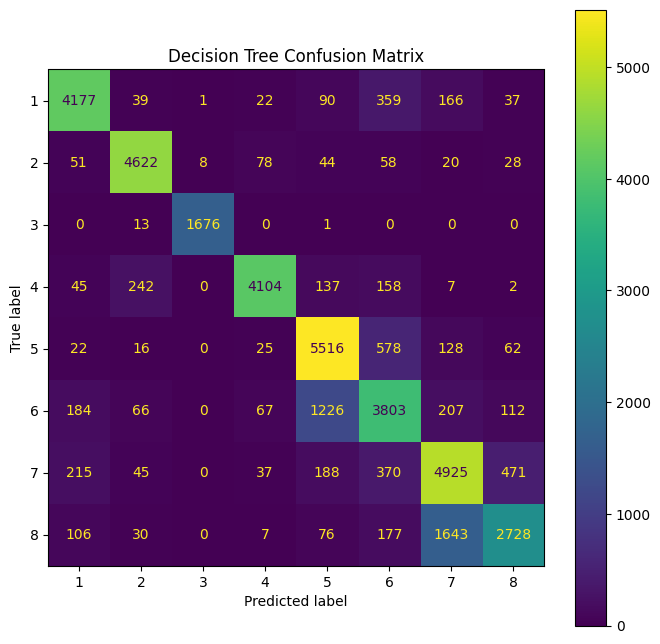

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute predictions if not already done
y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='viridis')
ax.set_title("Decision Tree Confusion Matrix")
plt.show()
